In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
RUTA_BD='BD'

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./scripts/SistemasRecomendacion') 

# Sistemas de recomendacion

## Tabla de contenidos
1. <a href="#seccion1">Sistemas de recomendacion</a>
2. <a href="#seccion2">Content Based</a>
3. <a href="#seccion3">CollaborativeFiltering</a>



<a id="seccion1"></a>
## Sistemas de recomendacion

Los sistemas de recomendación están extendidos en todo sitios y nos dicen donde comer, que ver, escuchar y incluso que amigos tener
<img src="imagenes/sisrec_amazon.png">

Los tipos mas extendidos son:
- **Content-Based**: Las recomendaciones son dadas por medio de los atributos del producto buscando productos similares
- **Collaborative Filtering**: Recomendaciones basadas en el comportamiento de otros individuos

<img src='imagenes/tipos_sistemas.png'>

<a id="seccion2"></a>
### Basado en el Contenido (ContendBased)

Por medio de la descripción del producto. Relaciones de tags

1. Vectorizacion del contenido, es decir, generar los tags
2. Ponderar los tags
3. Generar el motor de buscada de los productos similares

<img src='imagenes/contect_based.png'>

### Ejemplo1: Recomendacion de articulos basados en su contenido
Vamos a realizar una demostracion de sistema de recomendacion basado en contenido para recomendar articulos

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import ContendBased as CB

NOMBRE_COLUMNAS = ['UsuarioID','PeliculaID','Valoracion']

In [4]:
datos = pd.read_csv(RUTA_BD+"/people_wiki.csv")
datos.head(3)

,URI,name,text
0,<http://dbpedia.org/resource/Gigi_Rigamonti>,Gigi Rigamonti,gigi rigamonti born 8 april 1949 is an italian...
1,<http://dbpedia.org/resource/Steve_Anderson_(m...,Steve Anderson (musician),steve anderson was briefly a member of the ban...
2,<http://dbpedia.org/resource/Tenzin_Delek_Rinp...,Tenzin Delek Rinpoche,lithang tulku tenzin delek rinpoche or tenzing...


In [5]:
entrada_elton_john=datos.query('name == "Elton John"')
entrada_elton_john

,URI,name,text
10,<http://dbpedia.org/resource/Elton_John>,Elton John,sir elton hercules john cbe born reginald kenn...


#### Explorar los tags y su peso
1. Primero vamos a vertorizar (extración de los tags) la descripción del producto --> ```CountVectorizer()```
2. Calcular la importancia de cada tag en la descripcion del producto --> ```TfidfTransformer()```


##### Vectorizacion
Calculamos los tags

In [6]:
vectorizacion = CountVectorizer()
bag_of_words= vectorizacion.fit_transform(datos.text)

In [7]:
bag_words_elton_john = vectorizacion.transform(entrada_elton_john.text)
CB.mostrar_pesos_tags(bag_words_elton_john,vectorizacion)

,peso
tag_peso,
the,27
in,18
and,15
of,13
has,9
he,7
john,7
on,6


##### Normalizacion
Pesos los tags

In [8]:
tf_transformer = TfidfTransformer(use_idf=False).fit(bag_of_words)

In [9]:
matrix_elton_john_tf=tf_transformer.transform(bag_of_words[entrada_elton_john.index.values])
pesos_tf=CB.mostrar_pesos_tags(matrix_elton_john_tf,vectorizacion,descripcion='tf')
pesos_tf

,tf
tag_tf,
the,0.563848
in,0.375898
and,0.313249
of,0.271482
has,0.187949
he,0.146183
john,0.146183
on,0.125299


Fuck, los tags mas importante no describen los articulos
- **SOLUCION**: Normalizar y poderar teniendo en cuenta la frecuencia de cada tag en los demas documenos

In [10]:
tfidf_transformer = TfidfTransformer(use_idf=True).fit(bag_of_words)
matrix_elton_john_tf_idx=tfidf_transformer.transform(bag_of_words[entrada_elton_john.index.values])
pesos_tf_idx=CB.mostrar_pesos_tags(matrix_elton_john_tf_idx,vectorizacion,descripcion='tf-idx')
pesos_tf_idx

,tf-idx
tag_tf-idx,
the,0.245980
billboard,0.195711
john,0.189990
elton,0.186575
furnish,0.170638
in,0.164139
and,0.136804
songwriters,0.120128


Vamos por el buen camino, vamos a ayudar al algoritmo de dos formas:
1. Eliminando las palabras mas comunes --> ```stopwords```
2. Eliminado los numeros: Fuera de su contexto pierden todo su significado

In [11]:
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
cachedStopWords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [12]:
vectorizacion_stop_words     = CountVectorizer(stop_words = cachedStopWords, token_pattern='(?u)\\b[a-zA-Z]\\w\\w+\\b')
bag_of_words_stop_words      = vectorizacion_stop_words.fit_transform(datos.text)
tfidf_transformer_stop_words = TfidfTransformer(use_idf=True).fit(bag_of_words_stop_words)

In [13]:
matrix_elton_john_tf_idx_stop_words=tfidf_transformer_stop_words.transform(bag_of_words_stop_words[entrada_elton_john.index.values])
pesos_tf_idx_filtrado=CB.mostrar_pesos_tags(matrix_elton_john_tf_idx_stop_words,vectorizacion_stop_words,descripcion='tf_idx_filtrado')
pesos_tf_idx_filtrado

,tf_idx_filtrado
tag_tf_idx_filtrado,
billboard,0.230409
john,0.223674
elton,0.219654
furnish,0.200891
songwriters,0.141425
award,0.141251
top,0.140106
aids,0.132142


##### Comparativa de las mejoras realizadas
- **tf**: Poderamos y normalizados los tags de cada articulo
- **tf-idx**: Poderamos y normalizados los tags de cada articulo teniendo en cuenta la frecuencia de cada tag en los demas articulos
- **tf_idx_filtrado**: Eliminamos las palabras mas comunes y los numeros a tf-idx

In [14]:
pd.concat([pesos_tf.reset_index(level=0),pesos_tf_idx.reset_index(level=0),pesos_tf_idx_filtrado.reset_index(level=0)],axis=1)

,tag_tf,tf,tag_tf-idx,tf-idx,tag_tf_idx_filtrado,tf_idx_filtrado
0,the,0.563848,the,0.245980,billboard,0.230409
1,in,0.375898,billboard,0.195711,john,0.223674
2,and,0.313249,john,0.189990,elton,0.219654
3,of,0.271482,elton,0.186575,furnish,0.200891
4,has,0.187949,furnish,0.170638,songwriters,0.141425
5,he,0.146183,in,0.164139,award,0.141251
6,john,0.146183,and,0.136804,top,0.140106
7,on,0.125299,songwriters,0.120128,aids,0.132142


##### Forma rapida
Todos los pasos anteriores se puede simplificar por medio de un metodo de sklearn que los agrutina

In [15]:
tfidf_vectorizer = TfidfVectorizer( stop_words=cachedStopWords, token_pattern='(?u)\\b[a-zA-Z]\\w\\w+\\b')
tfidf_vectorizer.fit(datos.text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', '...aven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b[a-zA-Z]\\w\\w+\\b', tokenizer=None,
        use_idf=True, vocabulary=None)

In [16]:
CB.mostrar_pesos_tags(tfidf_vectorizer.transform(entrada_elton_john.text),tfidf_vectorizer)

,peso
tag_peso,
billboard,0.230409
john,0.223674
elton,0.219654
furnish,0.200891
songwriters,0.141425
award,0.141251
top,0.140106
aids,0.132142


##### Prediccion
Una vez que ya hemos extraidos los tags de los productos, buscamos por similitud los mas parecidos

In [17]:
vecinos            = NearestNeighbors(n_neighbors=5,metric='cosine',algorithm='brute')
datos_por_tags     = tfidf_vectorizer.transform(datos.text)

#### NOTA: Concepto de metrica
Decir similitud, necesariamente tenemos que hablar de metricas, normalmente utilizamos la ```euclidia``` en la vida real pero en sistemas recomendados, lo mas habitual es la llamada ```cosine```

Distancia Euclida: [[ 2.82842712]], Distancia cosine: [[  2.22044605e-16]]


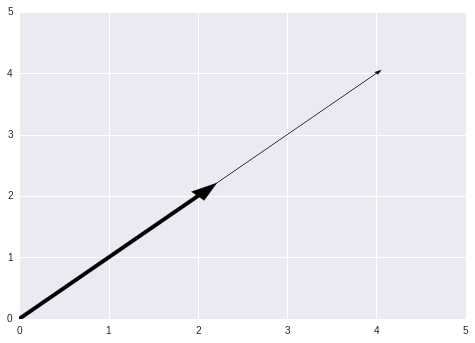

In [18]:
from sklearn.metrics.pairwise import pairwise_distances

a=np.array([2,2])
b=np.array([4,4])
print ("Distancia Euclida: {}, Distancia cosine: {}".format(pairwise_distances(a,b, metric='l2'),pairwise_distances(a,b, metric='cosine')))
ax1 = plt.axes(xlim=[0,5],ylim=[0,5])
ax1.arrow(0, 0, b[0], b[1], head_width=0.05, fc='k', ec='k')
ax1.arrow(0, 0, a[0], a[1], width=0.05,head_width=0.2, fc='k', ec='k')
plt.show()

In [19]:
vecinos.fit(datos_por_tags)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

Como se ve a continuacion, nos recomiendan articulos de cantantes, hemos triunfado

In [20]:
elton_john_vectorizado  = tfidf_vectorizer.transform(entrada_elton_john.text)
distancia,indices       = vecinos.kneighbors(elton_john_vectorizado)
datos.iloc[indices[0],:]

,URI,name,text
10,<http://dbpedia.org/resource/Elton_John>,Elton John,sir elton hercules john cbe born reginald kenn...
5227,<http://dbpedia.org/resource/Barbra_Streisand>,Barbra Streisand,barbra joan streisand born barbara joan streis...
134,<http://dbpedia.org/resource/Billy_Joel>,Billy Joel,william martin billy joel born may 9 1949 is a...
429,<http://dbpedia.org/resource/JoJo_(singer)>,JoJo (singer),joanna nolle blagden levesque born december 20...
10441,<http://dbpedia.org/resource/Pink_(singer)>,Pink (singer),alecia beth moore born september 8 1979 better...


#### Ejemplo de busqueda
Con todo lo anterior, ya estamos preparamos para crear un nuestro sistema de recomendacion basado en contenido

Vamos a buscar los actores que han podido ganar algun oscar

https://en.wikipedia.org/wiki/Academy_Award_for_Best_Actor

In [21]:
content_based = CB.ContentBased(stop_words=cachedStopWords, token_pattern='(?u)\\b[a-zA-Z]\\w\\w+\\b')
content_based.fit(datos,columna_descripcion='text')

Se puede comprobar que de los 5, 4 de ellos ha ganado por menos un oscar !!!!

In [22]:
content_based.predict(['Award Actor Oscar'])

,URI,name,text
185,<http://dbpedia.org/resource/Al_Pacino>,Al Pacino,alfredo james al pacino ptino born april 25 19...
10267,<http://dbpedia.org/resource/Ethan_Hawke>,Ethan Hawke,ethan green hawke born november 6 1970 is an a...
12795,<http://dbpedia.org/resource/Ralph_Fiennes>,Ralph Fiennes,ralph nathaniel twisletonwykehamfiennes ref fa...
3474,<http://dbpedia.org/resource/Daniel_Day-Lewis>,Daniel Day-Lewis,sir daniel michael blake daylewis kt born 29 a...
4677,<http://dbpedia.org/resource/Michael_Keaton>,Michael Keaton,michael john douglas born september 5 1951 bet...


In [23]:
content_based.predict(datos.query('name == "Al Pacino"').text)

,URI,name,text
185,<http://dbpedia.org/resource/Al_Pacino>,Al Pacino,alfredo james al pacino ptino born april 25 19...
12795,<http://dbpedia.org/resource/Ralph_Fiennes>,Ralph Fiennes,ralph nathaniel twisletonwykehamfiennes ref fa...
10267,<http://dbpedia.org/resource/Ethan_Hawke>,Ethan Hawke,ethan green hawke born november 6 1970 is an a...
3474,<http://dbpedia.org/resource/Daniel_Day-Lewis>,Daniel Day-Lewis,sir daniel michael blake daylewis kt born 29 a...
460,<http://dbpedia.org/resource/Jeff_Daniels>,Jeff Daniels,jeffrey warren jeff daniels born february 19 1...


<a id="seccion3"></a>

### Filtro Colaborativo (Collaborative Filtering)

Hay distintos modelos:
1. **Memory-Based**: Son mas bien sistemas heristicos, son faciles de impletar y producen predicciones razonables. Tiene un gran problema: No son escalables.
<img src='imagenes/collaborative_filter.png'>
2. **Model-Based**: Introducimos Machine Learning a los filtros colaborativos para que sean escalabres: calcular a partir de nuestra matriz de ranking dos matrices de menor rango que nos prediga el raking de los productos que no tienen  
<img src='imagenes/factorization.jpg'>
<h6 align="center">Imagen de http://www.jeremymcohen.net/posts/taste</h6> 

#### Model-Based
Los algoritmos que mas se utilizan son:
1. **Singular value decomposition (SVD)**
2. **Stochastic gradient descent (SGD)**: Sencillo pero muy poderoso
3. **Altering least squares (ALS)**: utilizaremos este metodo al estar optimizado a traves de spark <a href='https://www.quora.com/Why-are-there-two-ML-implementations-in-Spark-ML-and-MLlib-and-what-are-their-different-features'>(Utilizaremos el paquete de Machine Learning ml y no mllib)</a>

### Ejemplo2: Recomendacion de articulos por medio ALS basados en el sentimiento de cada usuario
A partir de la recomendacion de las 10 peliculas mas vistas por nosotros, el sistema nos recomendará otras

In [24]:
from pyspark import SparkConf, SparkContext
conf = (SparkConf()
         .setMaster("local[*]")
         .setAppName("Myapp")
         .set("spark.executor.memory", "1g"))
sc = SparkContext(conf = conf)
sc.setLogLevel("ERROR")



In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from math import sqrt
from operator import add
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

import CollaborativeFiltering as CF

USERID='user_id'
PRODUCTID='product_id'
PREDICCION ='prediccion'
NOMBRE_PELICULA='nombre_pelicula'
TARGET     ='rating'
    
def error_train_test(modelo,train,test,prediccion=PREDICCION,target=TARGET):
    return ( CF.rmse(modelo.transform(train),prediccion,target),
        CF.rmse(modelo.transform(test),prediccion,target))

In [26]:
historico_valoraciones=pd.read_csv(RUTA_BD+"/ratings.dat",sep='::',names = [USERID,PRODUCTID,TARGET],usecols=[0,1,2],engine='python')
relacion_peliculas=pd.read_csv(RUTA_BD+"/movies.dat",sep='::',names = [PRODUCTID,NOMBRE_PELICULA],usecols=[0,1],engine='python')

#### Generamos nuestas valoraciones
A partir de las peliculas mas vistras

In [27]:
id_peliculas_mas_vistas=historico_valoraciones.groupby(by=PRODUCTID).count().sort_values(by=USERID,ascending=False).head(10).index.values
id_peliculas_mas_vistas

array([2858, 1196,  260, 1210,  480, 2571, 2028,  589, 1580,  593])

In [28]:
peliculas_mas_vistas = relacion_peliculas[relacion_peliculas[PRODUCTID].isin(id_peliculas_mas_vistas)]
peliculas_mas_vistas

,product_id,nombre_pelicula
257,260,Star Wars: Episode IV - A New Hope (1977)
476,480,Jurassic Park (1993)
585,589,Terminator 2: Judgment Day (1991)
589,593,"Silence of the Lambs, The (1991)"
1178,1196,Star Wars: Episode V - The Empire Strikes Back...
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983)
1539,1580,Men in Black (1997)
1959,2028,Saving Private Ryan (1998)
2502,2571,"Matrix, The (1999)"
2789,2858,American Beauty (1999)


In [29]:
ranking_mio = []
for fila in peliculas_mas_vistas.itertuples():
    puntuacion = input("Puntuacion de 1 al 5 de {}: ".format(fila.nombre_pelicula))
    ranking_mio.append([0,fila.product_id,float(puntuacion)])
mis_valoraciones = pd.DataFrame(data=ranking_mio,columns=[USERID,PRODUCTID,TARGET])
mis_valoraciones[TARGET] = mis_valoraciones[TARGET].astype(np.float64,copy=False)


Puntuacion de 1 al 5 de Star Wars: Episode IV - A New Hope (1977): 5
Puntuacion de 1 al 5 de Jurassic Park (1993): 4
Puntuacion de 1 al 5 de Terminator 2: Judgment Day (1991): 2
Puntuacion de 1 al 5 de Silence of the Lambs, The (1991): 2
Puntuacion de 1 al 5 de Star Wars: Episode V - The Empire Strikes Back (1980): 5
Puntuacion de 1 al 5 de Star Wars: Episode VI - Return of the Jedi (1983): 5
Puntuacion de 1 al 5 de Men in Black (1997): 4
Puntuacion de 1 al 5 de Saving Private Ryan (1998): 3
Puntuacion de 1 al 5 de Matrix, The (1999): 3
Puntuacion de 1 al 5 de American Beauty (1999): 1


#### BUENAS PRACTICAS: Validacion Cruzada


```python
lista_error_trainig=[]
lista_error_tests=[]
max_iteraciones=[1,3,12,15,18,24]
for max_ite in max_iteraciones:
    algoritmo = ALS(regParam=0.001,rank=4,maxIter=max_ite, userCol=USERID, itemCol=PRODUCTID, ratingCol=TARGET)
    modelo=algoritmo.fit(train_data)
    (error_trainig,error_tests)=error_train_test(modelo,train_data,test_data,algoritmo.getPredictionCol(),algoritmo.getRatingCol())
    lista_error_trainig.append(error_trainig)
    lista_error_tests.append(error_tests)
    print ("MaxIteraciones: {}, ErrorValidacion: {}, ErrorTest: {}".format(max_ite,error_trainig,error_tests))  
    
MaxIteraciones: 1, ErrorValidacion: 2.944017127892633, ErrorTest: 3.3589322628528784
MaxIteraciones: 3, ErrorValidacion: 0.841464796797687, ErrorTest: 0.9710850706836164
MaxIteraciones: 12, ErrorValidacion: 0.798266313670666, ErrorTest: 0.9474099321913148
MaxIteraciones: 15, ErrorValidacion: 0.7970887322939875, ErrorTest: 0.9487053356238591
MaxIteraciones: 18, ErrorValidacion: 0.7962955748882709, ErrorTest: 0.9532481382416105
MaxIteraciones: 24, ErrorValidacion: 0.7954616942763565, ErrorTest: 0.958973712003286
```

<img src='imagenes/curva_de_validacion.png'>
  

Para cada tupla de parametros se itera tantas veces como hemos expecificado y se guarda la media de errores generados<br/>
Eligemos el modelo con menor error medio
<img src='imagenes/validacion_cruzada.jpg'>

#### Conjunto de entrenamiento y testeo

Vamos a crear dos conjuntos para poder afinar los hiperparametros del algoritmo ALS:
- **Entrenamiento:** Con este conjunto de datos se validan los hiperparametros del modelo
- **Tests:** Una vez que nuestro modelo está entrenado con unos hiperparaemtros adecuados, se testea con otro conjunto el desempeño del modelo

In [30]:
from sklearn.cross_validation import train_test_split  
X_historico, X_test = train_test_split(
    historico_valoraciones, test_size=0.3, random_state=0)

# Añado mis recomendaciones
X_train = pd.concat([mis_valoraciones,X_historico])

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

train_data = sqlContext.createDataFrame(data=X_train).cache()
test_data = sqlContext.createDataFrame(data=X_test).cache()

In [31]:
algoritmo = ALS(rank=5,userCol=USERID, itemCol=PRODUCTID, ratingCol=TARGET)
grid_parametros = ParamGridBuilder().addGrid(algoritmo.regParam, [0.1,0.25,0.5]).build()
evaluador = CF.EvaluadorRMSE(predictionCol=algoritmo.getPredictionCol(), targetCol=algoritmo.getRatingCol())

cv = CrossValidator(estimator=algoritmo, estimatorParamMaps=grid_parametros, evaluator=evaluador, numFolds=2)
cv_model = cv.fit(train_data)

Error: 0.9745942013521549
Error: 0.96128354042692
Error: 1.0614269698693257
Error: 0.971314154544693
Error: 0.9605187632019755
Error: 1.0613141947823428


In [32]:
(error_training_als,error_test_als)=error_train_test(cv_model,train_data,test_data,algoritmo.getPredictionCol(),algoritmo.getRatingCol())
print ("ErrorValidacion: {}, ErrorTest: {}".format(error_training_als,error_test_als))

ErrorValidacion: 0.8912099740200381, ErrorTest: 0.9408279573788174


#### Prediccion
Hemos creado un envoltorio al modelo ALS para ayudarnos a generar predicciones a partir de las matrices con los factores ocultos


Rating de nuestras valoraciones

In [35]:
mb_als=CF.ModelBasedALS(cv_model.bestModel)

In [36]:
pd.merge(mis_valoraciones,mb_als.predictAll(mis_valoraciones.iloc[:,[0,1]]))

,user_id,product_id,rating,prediccion
0,0,260,5.0,3.396159
1,0,480,4.0,3.042679
2,0,589,2.0,3.144846
3,0,593,2.0,3.225735
4,0,1196,5.0,3.309826
5,0,1210,5.0,3.145668
6,0,1580,4.0,2.959501
7,0,2028,3.0,3.391782
8,0,2571,3.0,3.368667
9,0,2858,1.0,2.978276


Películas que nos recomiendan

In [38]:
relacion_peliculas.join(mb_als.recommendProducts(0,10),how='right')

,product_id,nombre_pelicula,0
3161,3230,"Odessa File, The (1974)",4.228566
394,398,Frank and Ollie (1995),3.961015
3612,3681,For a Few Dollars More (1965),3.931430
3284,3353,"Closer You Get, The (2000)",3.802494
3371,3440,Teenage Mutant Ninja Turtles III (1993),3.740117
116,118,If Lucy Fell (1996),3.737218
1423,1448,Fire on the Mountain (1996),3.725733
3456,3525,Bachelor Party (1984),3.720174
3292,3361,Bull Durham (1988),3.710753
3776,3846,Easy Money (1983),3.698557



#### Hora de la verdad
Vamos a comparar el sistema con un modelo base definido como la media de las valoraciones en el conjunto entrenado

In [39]:
valoracion_media = X_train[TARGET].mean()
prediccion = (X_test[TARGET]-valoracion_media)**2
rmse_modelo_base = sqrt(prediccion.sum()/prediccion.count())

In [40]:
print ("la mejora del modelo ALS respecto al modelo base es: {0:.2f}%".format((rmse_modelo_base-error_test_als)/rmse_modelo_base*100))

la mejora del modelo ALS respecto al modelo base es: 14.89%
